In [13]:
# The homework files for group 30 (Malte Restorff, Wilfred Okajevo, Marvin Wurch) week 2


import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [14]:
class GridWorld:
    def __init__(self, rows, cols, start, goal, walls={}, traps={}, max_steps=10000):
        self.rows = rows  # Number of rows in the grid
        self.cols = cols  # Number of columns in the grid
        self.start = start  # Starting position of the agent
        self.goal = goal  # Goal position that the agent should reach
        self.walls = walls  # Set of wall positions, which are non-passable
        self.traps = traps  # Set of trap positions, which give a negative reward when passed
        self.state = start  # Current position of the agent
        self.actions = ["LEFT", "UP", "RIGHT", "DOWN"]  # List of possible actions
        self.total_reward = 0  # Accumulated reward
        self.max_steps = max_steps  # Maximum number of steps per episode
        self.current_steps = 0  # Current number of steps in the episode

    def reset(self):
        """Reset the environment to its initial state and set total_reward and current_steps to 0."""
        self.state = self.start
        self.total_reward = 0
        self.current_steps = 0
        return self.state

    def is_terminal(self, state):
        """Check if the given state is terminal (i.e., the goal state)."""
        return state == self.goal

    def step(self, action):
        """
        Take a step in the environment based on the given action.

        This method updates the agent's position and returns the next state, reward, and
        whether the state is terminal. The reward structure is as follows:
        - A small penalty for each step (-0.1)
        - An additional penalty for stepping on a trap (-1)
        - A bonus for reaching the goal (1)
        """
        assert action in self.actions, "Invalid action"

        x, y = self.state

        if action == "LEFT":
            y = max(y - 1, 0)
        elif action == "UP":
            x = max(x - 1, 0)
        elif action == "RIGHT":
            y = min(y + 1, self.cols - 1)
        elif action == "DOWN":
            x = min(x + 1, self.rows - 1)

        next_state = (x, y)
        reward = -0.1  # Add a small penalty for each step
        done = False

        if next_state in self.walls:
            next_state = self.state
        elif next_state in self.traps:
            reward += -1
        elif self.is_terminal(next_state):
            reward += 1
            done = True
            self.reset()

        self.total_reward += reward
        self.state = next_state
        self.current_steps += 1

        # Check if the maximum number of steps is reached
        if self.current_steps >= self.max_steps:
            self.reset()

        return next_state, reward, done  # Return the next state, the immediate reward and if episode is done
    
    def render(self):
        """
        Render the current state of the grid world.

        This method displays the playing field using simple characters to represent
        different elements of the grid:
        - 'S': start
        - 'G': goal
        - 'W': wall
        - 'T': trap
        - 'A': agent
        - ' ': empty space
        """
        for r in range(self.rows):
            for c in range(self.cols):
                cell = (r, c)
                if cell == self.start:
                    print("  S  ", end="")
                elif cell == self.goal:
                    print("  G  ", end="")
                elif cell in self.walls:
                    print("  W  ", end="")
                elif cell in self.traps:
                    print("  T  ", end="")
                else:
                    print("  .  ", end="")
            print()

In [15]:
class Agent:
    def __init__(self, gridworld):
        # Store state and action dimension 
        self.state_dim = (gridworld.rows, gridworld.cols)
        self.action_dim = (len(gridworld.actions),)
        # Initialize the agent with a list of possible actions
        self.actions = gridworld.actions
        # actions as dict
        self.action_indices = {action: i for i, action in enumerate(self.actions)}
        # Agent learning parameters
        self.epsilon = 1.0  # initial exploration probability
        self.epsilon_decay = 0.99  # epsilon decay after each episode
        self.beta = 0.99  # learning rate
        self.gamma = 0.99  # reward discount factor
        # Initialize Q[s,a] table
        self.Q = np.zeros(self.state_dim + self.action_dim, dtype=float)


    def get_action(self, gridworld):
        # Epsilon-greedy agent policy
        if random.uniform(0, 1) < self.epsilon:
            # explore
            return np.random.choice(self.actions)
        else:
            # exploit on allowed actions
            state = gridworld.state
            Q_s = self.Q[state[0], state[1], :]
            actions_greedy = [self.actions[i] for i in np.flatnonzero(Q_s == np.max(Q_s))]
            return np.random.choice(actions_greedy)

    def train(self, memory):
        # -----------------------------
        # Update:
        #
        # Q[s,a] <- Q[s,a] + beta * (R[s,a] + gamma * max(Q[s,:]) - Q[s,a])
        #
        #  beta = learning rate
        #  gamma = discount factor
        # -----------------------------
        (state, action, state_next, reward, done) = memory
        sa = state + (self.action_indices[action],)
        self.Q[sa] += self.beta * (reward + self.gamma*np.max(self.Q[state_next]) - self.Q[sa])

    def get_arrow(self, action_idx):
        # helper function for better visualization
        if action_idx == 0:
            return "←"
        elif action_idx == 1:
            return "↑"
        elif action_idx == 2:
            return "→"
        elif action_idx == 3:
            return "↓"
        
    def display_greedy_policy(self, gridworld):
        # for a nice visualization of the final policy
        greedy_policy = np.zeros((gridworld.rows, gridworld.cols), dtype=int)
        for r in range(gridworld.rows):
            for c in range(gridworld.cols):
                greedy_policy[r, c] = np.argmax(self.Q[r, c, :])

        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xticks(np.arange(-.5, gridworld.cols, 1))
        ax.set_yticks(np.arange(-.5, gridworld.rows, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_xlim(-0.5, gridworld.cols - 0.5)
        ax.set_ylim(-0.5, gridworld.rows - 0.5)
        ax.grid(True, color="k", linestyle="-", linewidth=1)

        for r in range(gridworld.rows):
            for c in range(gridworld.cols):
                cell = (r, c)
                if cell == gridworld.start:
                    ax.text(c, r, "S", fontsize=20, ha="center", va="center")
                    arrow = self.get_arrow(greedy_policy[r, c])
                    ax.text(c, r, arrow, fontsize=20, ha="center", va="top")
                elif cell == gridworld.goal:
                    ax.text(c, r, "G", fontsize=20, ha="center", va="center")
                elif cell in gridworld.walls:
                    ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor="k"))
                elif cell in gridworld.traps:
                    ax.add_patch(plt.Rectangle((c - 0.5, r - 0.5), 1, 1, facecolor="red"))
                    arrow = self.get_arrow(greedy_policy[r, c])
                    ax.text(c, r, arrow, fontsize=20, ha="center", va="center")
                else:
                    arrow = self.get_arrow(greedy_policy[r, c])
                    ax.text(c, r, arrow, fontsize=20, ha="center", va="center")
        plt.gca().invert_yaxis()
        plt.show()

In [16]:
# Example Girdworlds
empty_gridworld = GridWorld(rows=4, cols=4, start=(0, 0), goal=(3, 3))
simple_gridworld = GridWorld(rows=4, cols=4, start=(0, 0), goal=(3, 3),
                              walls={(1, 1), (2, 1)},
                              traps={(1, 3), (2, 3)})

complex_gridworld = GridWorld(rows=5, cols=5, start=(0, 0), goal=(4, 4),
                               walls={(1, 1), (1, 2), (2, 1), (2, 3), (3, 3), (3, 4)},
                               traps={(3, 0), (3, 1), (4, 1), (4, 3)})

complex_gridworld2 = GridWorld(rows=6, cols=6, start=(0, 0), goal=(5, 5),
                               walls={(1, 1), (1, 2), (1, 4), (2, 4), (3, 1), (3, 3), (4, 1), (4, 3), (4, 4), (5, 1)},
                               traps={(2, 2), (2, 3), (4, 2)})



narrow_path_gridworld = GridWorld(rows=6, cols=6, start=(0, 0), goal=(5, 5),
                                   walls={(1, 0), (1, 1), (1, 2), (1, 3), (1, 4),
                                          (3, 1), (3, 2), (3, 3), (3, 4), (3, 5)},
                                   traps={(4, 0), (4, 5)})


# empty_gridworld.render()
# print()
# simple_gridworld.render()
# print()
# complex_gridworld.render()
# print()
complex_gridworld2.render()
# print()
# narrow_path_gridworld.render()

  S    .    .    .    .    .  
  .    W    W    .    W    .  
  .    .    T    T    W    .  
  .    W    .    W    .    .  
  .    W    T    W    W    .  
  .    W    .    .    .    G  


In [17]:
def train_agent_on_gridworld(agent, gridworld, N_episodes=250):
    
    print("\nTraining agent on the given gridworld...\n")
    
    # Lists for recording rewards, episode lengths, and average Return-per-Episode
    rewards = []
    episode_lengths = []
    avg_returns = []

    # List for recording wall-clock time
    wallclock_times = []

    start_time = time.time()

    for episode in range(N_episodes):

        # Generate an episode
        iter_episode, reward_episode = 0, 0
        state = gridworld.reset()  # starting state
        while True:
            action = agent.get_action(gridworld)  # get action
            state_next, reward, done = gridworld.step(action)  # evolve state by action
            agent.train((state, action, state_next, reward, done))  # train agent
            iter_episode += 1
            reward_episode += reward
            if done:
                break
            state = state_next  # transition to next state

        # Decay agent exploration parameter - total min of 0.01
        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, 0.01)

        # Record rewards, episode lengths, and wall-clock time
        rewards.append(reward_episode)
        episode_lengths.append(iter_episode)
        wallclock_times.append(time.time() - start_time)

        # Calculate average Return-per-Episode for all episodes up to the current point
        avg_returns.append(np.mean(rewards))


    # Plot the results
    fig, ax = plt.subplots(2, 1, figsize=(12, 8))
  
    ax[0].plot(avg_returns)
    ax[0].set_title('Average Return-per-Episode')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Average Return')

    ax[1].plot(wallclock_times, avg_returns)
    ax[1].set_title('Average Return-per-Episode vs Wall-clock Time')
    ax[1].set_xlabel('Wall-clock Time (seconds)')
    ax[1].set_ylabel('Average Return')

    plt.tight_layout()
    plt.show()

    # Print greedy policy
    if (episode == N_episodes - 1):
        agent.display_greedy_policy(gridworld)




Training agent on the given gridworld...



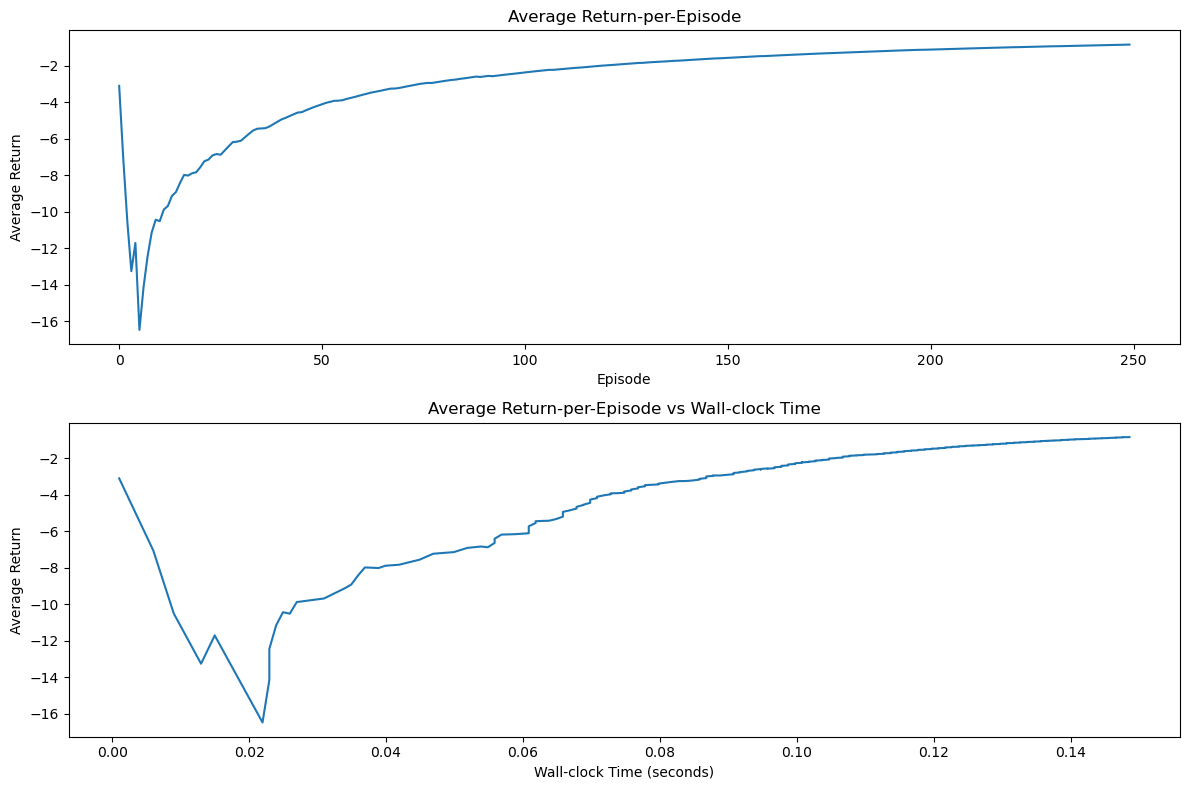

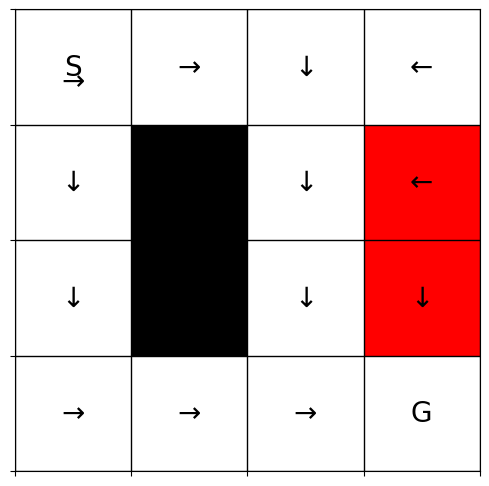


Training agent on the given gridworld...



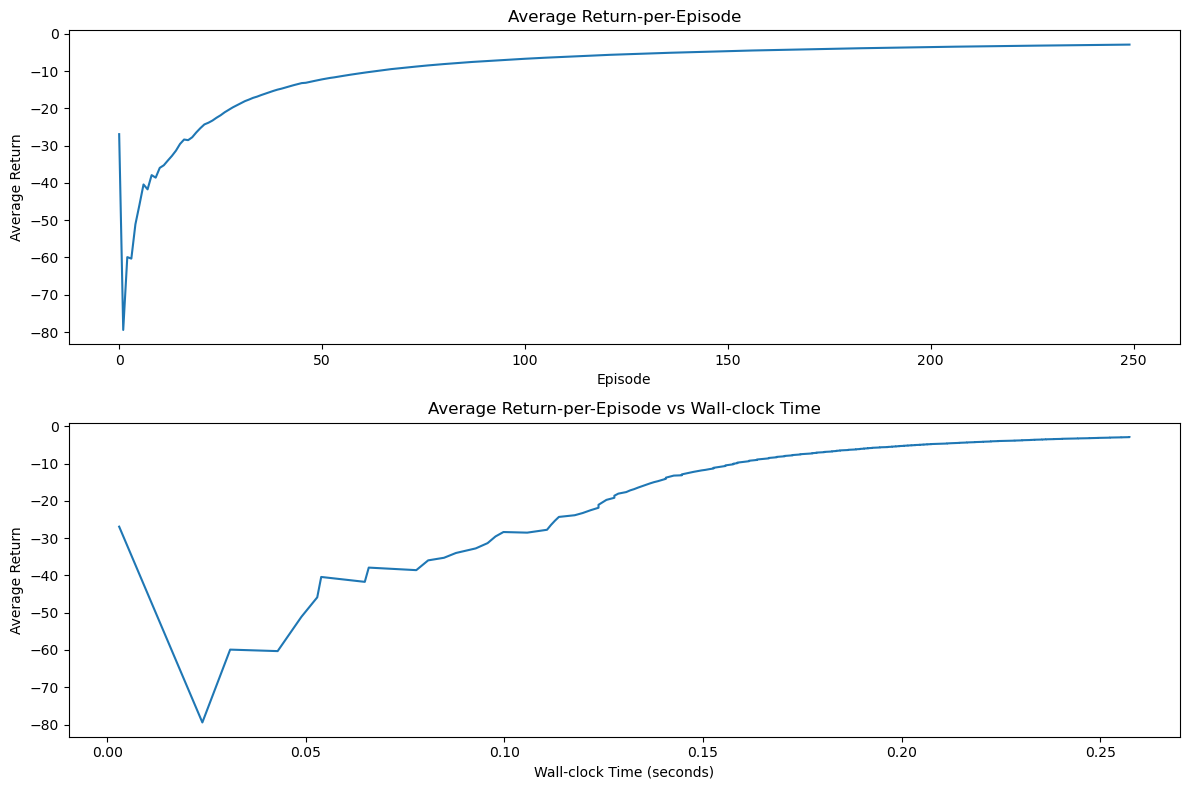

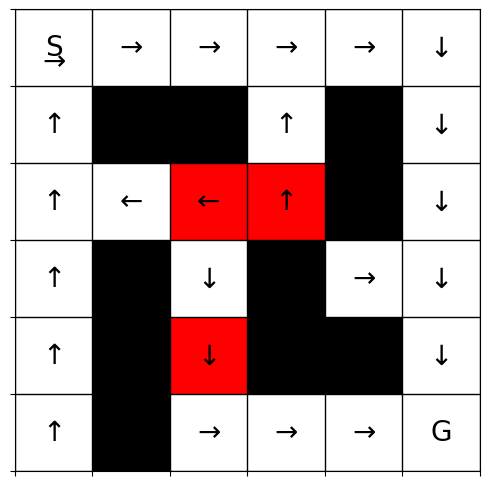

In [18]:
# agent_empty = Agent(empty_gridworld)
# train_agent_on_gridworld(agent_empty, empty_gridworld)

agent_simple = Agent(simple_gridworld)
train_agent_on_gridworld(agent_simple, simple_gridworld)

# agent_complex = Agent(complex_gridworld)
# train_agent_on_gridworld(agent_complex, complex_gridworld, 10000)

agent_complex2 = Agent(complex_gridworld2)
train_agent_on_gridworld(agent_complex2, complex_gridworld2)

# agent_narrow_path = Agent(narrow_path_gridworld)
# train_agent_on_gridworld(agent_narrow_path, narrow_path_gridworld)
